#PhlyGreen Tutorial 

Import packages

In [60]:
import sys
sys.path.append('../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [61]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)

Create instance of Aircraft object.

In [62]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)

Create the connections with its subsystems.

In [63]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [64]:
ConstraintsInput = {'speed': np.array([0.5, 90, 210, 210, 0.5, 0.35, 59.]) ,
                    'speedtype': ['Mach','TAS','KCAS','KCAS','Mach','Mach','TAS']   ,
                    'beta': np.array([0.95,1.,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [65]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.97,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [66]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [67]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.87,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

In [68]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}}}

Import input dictionaries

In [69]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput

Set aircraft power configuration

In [70]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [71]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

Either run the Constraint Analysis....

In [72]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3253.0606060606065
Design P/W:  195.34870676278987
----------------------------------------


... or assign a wing loading

In [73]:
#myaircraft.DesignWTOoS = 2121

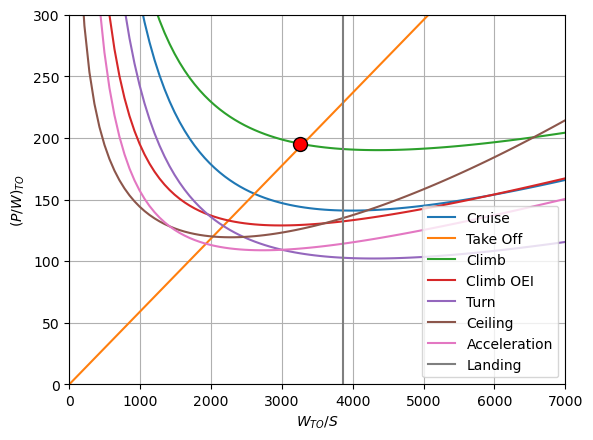

In [74]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [75]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [76]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [77]:
print('----------------------------------------')
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight [Kg]:          ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface [m^2]: ', myaircraft.WingSurface)
print('TakeOff shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('Sizing phase for thermal powertrain: ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )

----------------------------------------
Fuel mass (trip + altn) [Kg]:  1632.8402769098668
Block Fuel mass [Kg]:          2132.8402769098666
Structure [Kg]:                10316.858979998502
Powertrain mass [Kg]:          1099.6491268582924
Empty Weight [Kg]:             11916.508106856794
Zero Fuel Weight [Kg]:         16476.508106856796
----------------------------------------
Takeoff Weight [Kg]:           18609.307404756582
Wing Surface [m^2]:  56.11863034477413
TakeOff shaft peak power [kW]:       4288.63159474734
Climb/cruise shaft peak power [kW]:  3573.982767523834
Sizing phase for thermal powertrain:  Takeoff peak power


Some plots:

In [78]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

Take-Off Propulsive Power over Takeoff Mass

In [79]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.ConstraintsBeta[1], myaircraft.constraint.ConstraintsAltitude[1], myaircraft.constraint.kTO, myaircraft.constraint.sTO, myaircraft.constraint.DISA, myaircraft.constraint.ConstraintsSpeed[1], myaircraft.constraint.ConstraintsSpeedtype[1])

192.4765605833035

Maximum mission Propusive Power over Takeoff Mass

In [80]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

160.40265886198398

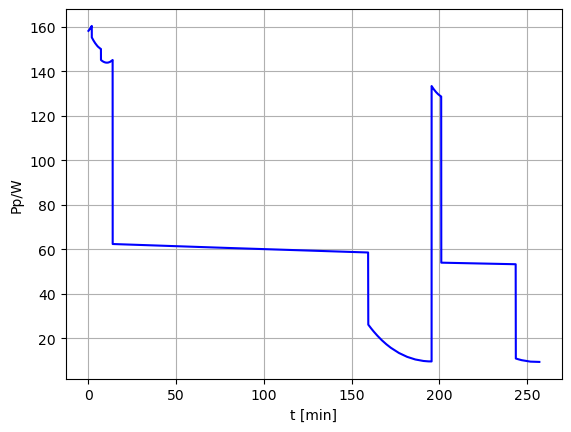

In [81]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

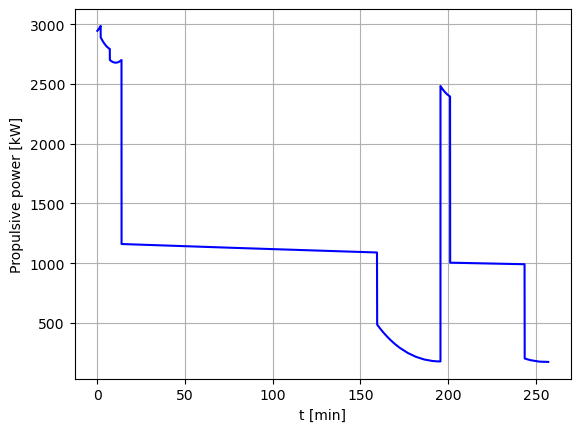

In [82]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive power [kW]')
plt.show()

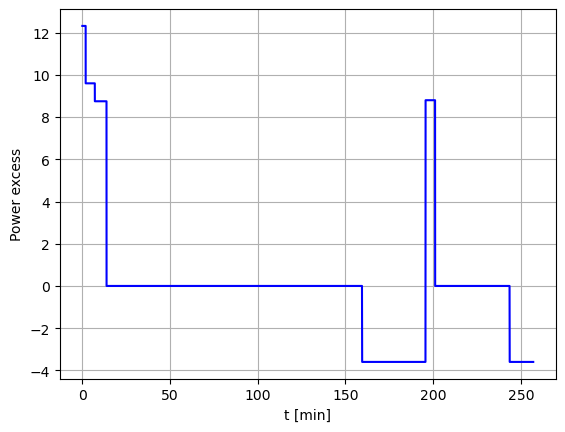

In [83]:
plt.plot(times/60,[myaircraft.mission.profile.PowerExcess(times[t]) for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Power excess')
plt.show()

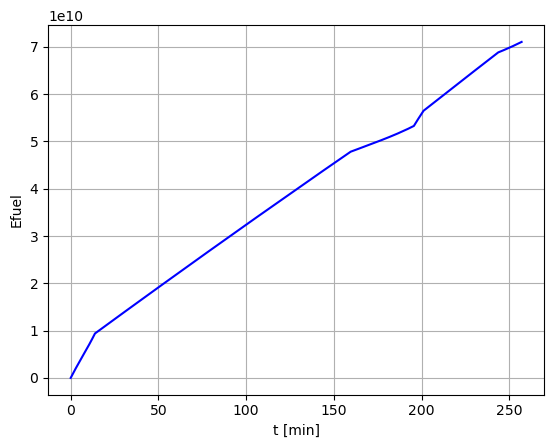

In [84]:
plt.plot(times/60,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

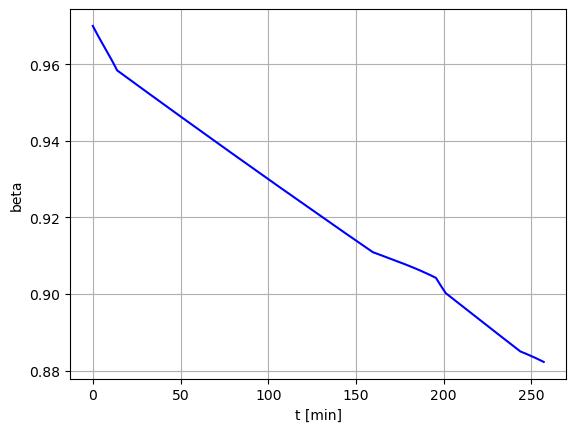

In [85]:
plt.plot(times/60,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

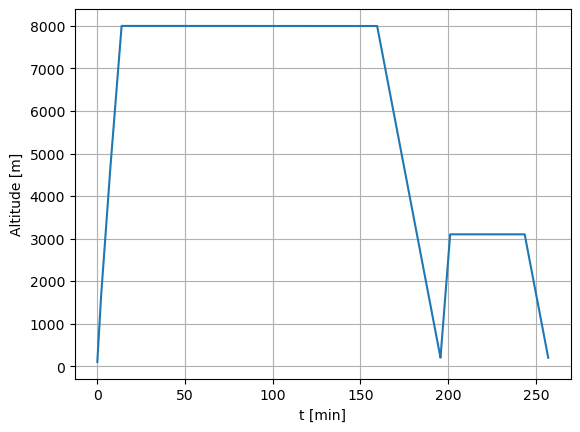

In [86]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

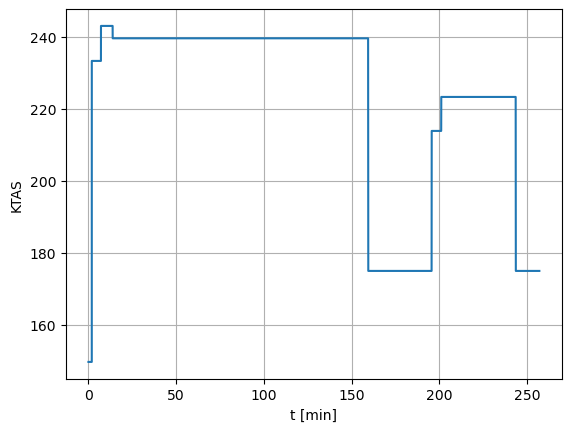

In [87]:
plt.plot(times/60,pg.Utilities.Units.MtoKN(mission.profile.Velocity(times)))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('KTAS')
plt.show()

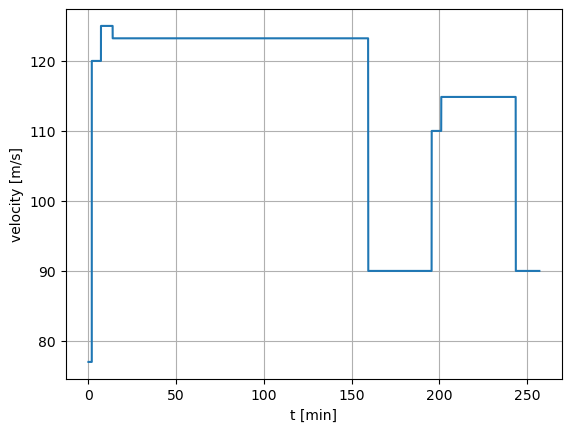

In [88]:
plt.plot(times/60,mission.profile.Velocity(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('velocity [m/s]')
plt.show()

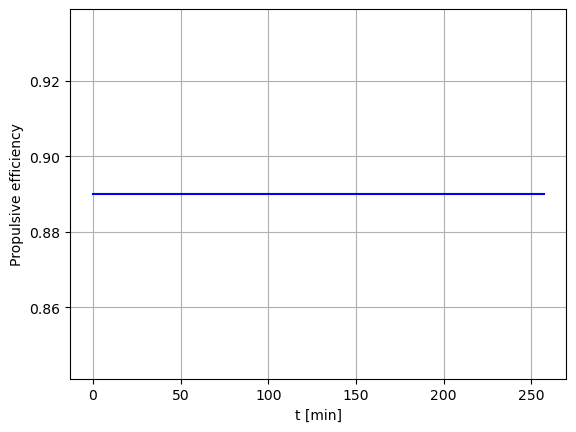

In [89]:
etaPP = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    etaPP[t]= myaircraft.powertrain.EtaPPpw127Model(alt, v, power)
plt.plot(times/60,etaPP, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive efficiency')
plt.show()

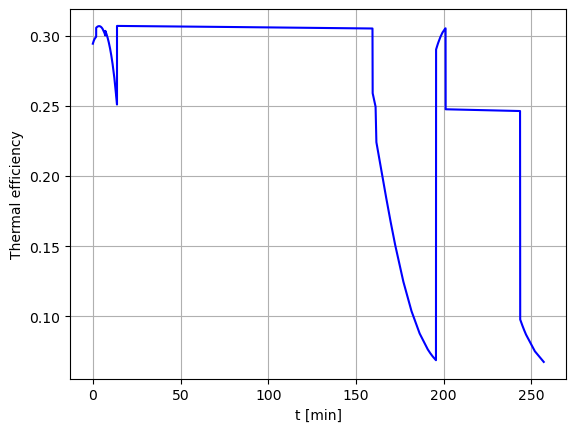

In [94]:
if myaircraft.EnergyInput['Eta Gas Turbine Model'] == 'PW127':
    etaTh = np.zeros(len(times))
    for t in range(len(times)):
        alt = myaircraft.mission.profile.Altitude(times[t])
        v = myaircraft.mission.profile.Velocity(times[t])
        power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
        etaTh[t]= myaircraft.powertrain.EtaGTpw127Model(alt, v, power)
    plt.plot(times/60,etaTh, 'b')
    plt.grid(visible=True)
    plt.xlabel('t [min]')
    plt.ylabel('Thermal efficiency')
    plt.show()

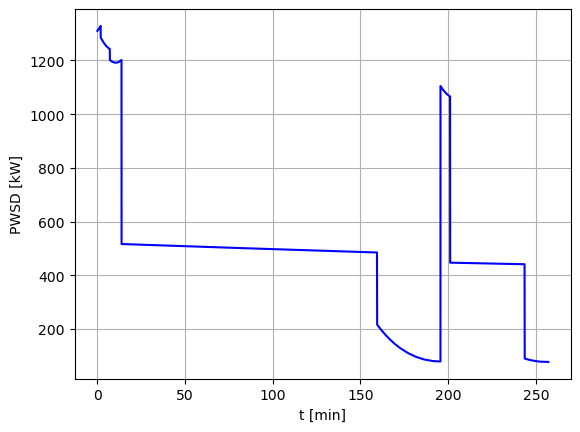

In [91]:
pwsd = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    pwsd[t]= 1e-3*0.5*0.89*power
plt.plot(times/60,pwsd, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('PWSD [kW]')
plt.show()

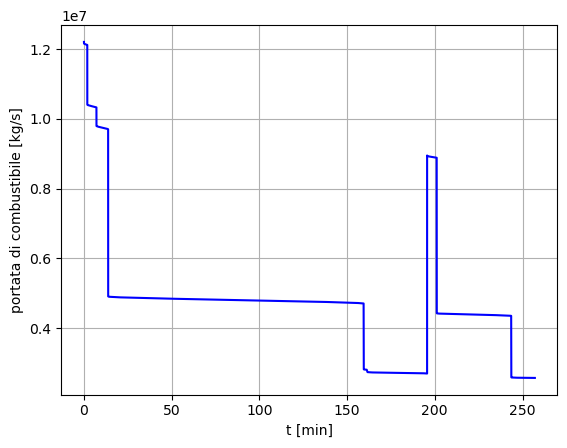

In [97]:
dEdt = np.zeros(len(times))
for t in range(len(times)):
    PP = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    PRatio = myaircraft.powertrain.Traditional(myaircraft.mission.profile.Altitude(t),myaircraft.mission.profile.Velocity(t),PP)
    dEdt[t] = PP * PRatio[0]
plt.plot(times/60,dEdt, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('portata di combustibile [kg/s]')
plt.show()
 
